In [ ]:
import os
import zipfile
from google.colab import files

os.chdir('/content')
CODE_DIR = 'idinvert'

os.chdir(f'./{CODE_DIR}')
MODEL_DIR = os.path.join('models', 'pretrain')
!nvidia-smi


Thu Nov 17 01:10:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    69W /  70W |  10970MiB / 15109MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# functions

In [ ]:
# python 3.6
"""Demo."""
import os
import sys
import io
import bz2
import requests
import dlib
import numpy as np
from PIL import Image
import IPython.display
import scipy.ndimage
from google.colab import files
from google.colab import output
from utils.editor import manipulate
from utils.inverter import StyleGANInverter
from models.helper import build_generator


LANDMARK_MODEL_NAME = 'shape_predictor_68_face_landmarks.dat'
LANDMARK_MODEL_PATH = os.path.join(MODEL_DIR, LANDMARK_MODEL_NAME)
LANDMARK_MODEL_URL = f'http://dlib.net/files/{LANDMARK_MODEL_NAME}.bz2'
model_name = 'styleganinv_ffhq256'
pre = 'examples'
inverted_code_dir = 'inverted_codes'
os.makedirs(inverted_code_dir, exist_ok=True)

class FaceLandmarkDetector(object):
  """Class of face landmark detector."""

  def __init__(self, align_size=256, enable_padding=True):
    """Initializes face detector and landmark detector.

  Args:
    align_size: Size of the aligned face if performing face alignment.
    (default: 1024)
    enable_padding: Whether to enable padding for face alignment (default:
    True)
  """
    # Download models if needed.
    if not os.path.exists(LANDMARK_MODEL_PATH):
      data = requests.get(LANDMARK_MODEL_URL)
      data_decompressed = bz2.decompress(data.content)
      with open(LANDMARK_MODEL_PATH, 'wb') as f:
        f.write(data_decompressed)

    self.face_detector = dlib.get_frontal_face_detector()
    self.landmark_detector = dlib.shape_predictor(LANDMARK_MODEL_PATH)
    self.align_size = align_size
    self.enable_padding = enable_padding

  def detect(self, image_path):
    """Detects landmarks from the given image.

  This function will first perform face detection on the input image. All
  detected results will be grouped into a list. If no face is detected, an
  empty list will be returned.

  For each element in the list, it is a dictionary consisting of `image_path`,
  `bbox` and `landmarks`. `image_path` is the path to the input image. `bbox`
  is the 4-element bounding box with order (left, top, right, bottom), and
  `landmarks` is a list of 68 (x, y) points.

  Args:
    image_path: Path to the image to detect landmarks from.

  Returns:
    A list of dictionaries, each of which is the detection results of a
    particular face.
  """
    results = []

    # image_ = np.array(image)
    images = dlib.load_rgb_image(image_path)
    # Face detection (1 means to upsample the image for 1 time.)
    bboxes = self.face_detector(images, 1)
    # Landmark detection
    for bbox in bboxes:
      landmarks = []
      for point in self.landmark_detector(images, bbox).parts():
        landmarks.append((point.x, point.y))
      results.append({
          'image_path': image_path,
          'bbox': (bbox.left(), bbox.top(), bbox.right(), bbox.bottom()),
          'landmarks': landmarks,
      })
    return results

  def align(self, face_info):
    """Aligns face based on landmark detection.

  The face alignment process is borrowed from
  https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py,
  which only supports aligning faces to square size.

  Args:
    face_info: Face information, which is the element of the list returned by
    `self.detect()`.

  Returns:
    A `np.ndarray`, containing the aligned result. It is with `RGB` channel
    order.
  """
    img = Image.open(face_info['image_path'])

    landmarks = np.array(face_info['landmarks'])
    eye_left = np.mean(landmarks[36: 42], axis=0)
    eye_right = np.mean(landmarks[42: 48], axis=0)
    eye_middle = (eye_left + eye_right) / 2
    eye_to_eye = eye_right - eye_left
    mouth_middle = (landmarks[48] + landmarks[54]) / 2
    eye_to_mouth = mouth_middle - eye_middle

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_middle + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Shrink.
    shrink = int(np.floor(qsize / self.align_size * 0.5))
    if shrink > 1:
      rsize = (int(np.rint(float(img.size[0]) / shrink)),
               int(np.rint(float(img.size[1]) / shrink)))
      img = img.resize(rsize, Image.ANTIALIAS)
      quad /= shrink
      qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))),
            int(np.ceil(max(quad[:, 0]))), int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0),
            max(crop[1] - border, 0),
            min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
      img = img.crop(crop)
      quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))),
           int(np.ceil(max(quad[:, 0]))), int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0),
           max(-pad[1] + border, 0),
           max(pad[2] - img.size[0] + border, 0),
           max(pad[3] - img.size[1] + border, 0))
    if self.enable_padding and max(pad) > border - 4:
      pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
      img = np.pad(np.float32(img),
                   ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)),
                   'reflect')
      h, w, _ = img.shape
      y, x, _ = np.ogrid[:h, :w, :1]
      mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0],
                                         np.float32(w - 1 - x) / pad[2]),
                        1.0 - np.minimum(np.float32(y) / pad[1],
                                         np.float32(h - 1 - y) / pad[3]))
      blur = qsize * 0.02
      blurred_image = scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img
      img += blurred_image * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
      img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
      img = Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
      quad += pad[:2]

    # Transform.
    img = img.transform((self.align_size * 4, self.align_size * 4), Image.QUAD,
                        (quad + 0.5).flatten(), Image.BILINEAR)
    img = img.resize((self.align_size, self.align_size), Image.ANTIALIAS)

    return np.array(img)


def align_face(image_path, align_size=256):
  """Aligns a given face."""
  model = FaceLandmarkDetector(align_size)
  face_infos = model.detect(image_path)
  if len(face_infos) == 0:
    return None
  else:
    face_infos = face_infos[0]
    img = model.align(face_infos)
    return img


def build_inverter(model_name, iteration=100, regularization_loss_weight=2):
  """Builds inverter"""
  inverter = StyleGANInverter(
      model_name,
      learning_rate=0.01,
      iteration=iteration,
      reconstruction_loss_weight=1.0,
      perceptual_loss_weight=5e-5,
      regularization_loss_weight=regularization_loss_weight)
  return inverter


def get_generator(model_name):
  """Gets model by name"""
  return build_generator(model_name)


def align(inverter, image_path):
  """Aligns an unloaded image."""
  aligned_image = align_face(image_path,
                             align_size=inverter.G.resolution)
  return aligned_image


def invert(inverter, image):
  """Inverts an image."""
  latent_code, reconstruction = inverter.easy_invert(image, num_viz=1)
  return latent_code, reconstruction


def diffuse(inverter, target, context, left, top, width, height):
  """Diffuses a target image to a context image."""
  center_x = left + width // 2
  center_y = top + height // 2
  _, diffusion = inverter.easy_diffuse(target=target,
                                       context=context,
                                       center_x=center_x,
                                       center_y=center_y,
                                       crop_x=width,
                                       crop_y=height,
                                       num_viz=1)
  return diffusion


def load_image(path):
  """Loads an image from disk.

  NOTE: This function will always return an image with `RGB` channel order for
  color image and pixel range [0, 255].

  Args:
    path: Path to load the image from.

  Returns:
    An image with dtype `np.ndarray` or `None` if input `path` does not exist.
  """
  if not os.path.isfile(path):
    return None

  image = Image.open(path)
  return image

def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  if channels == 4:
    Image.fromarray(fused_image).save(data, 'png')
  elif channels == 3:
    Image.fromarray(fused_image).save(data, 'jpeg')
  else:
    raise ValueError('Image channel error')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp


# GAN inversion

In [ ]:
if not os.path.exists('./data'):
  os.mkdir('./data')

zip_path = './data/3000.zip'
data_folder = './data'

with zipfile.ZipFile(zip_path, 'r') as ziphandler:
  ziphandler.extractall(data_folder)

print('Dataset fully extracted.')

Dataset fully extracted.


In [ ]:
data_folder = os.path.join(data_folder, '3000')

image_names = [i for i in os.listdir(data_folder) if i.lower().endswith('jpg')]
print('number of images: %s'%len(image_names))


number of images: 1000


In [ ]:
def get_invert(image_name, inverted_code_dir):

  latent_code_path = os.path.join(inverted_code_dir, 
                                  image_name.split('.')[0] + '.npy')
  if os.path.exists(latent_code_path):
    latent_code = np.load(latent_code_path)
    return latent_code

  inverter = build_inverter(model_name=model_name)
  generator = get_generator(model_name)
  output.clear()

  mani_image = align(inverter, os.path.join(data_folder,image_name))
  if mani_image is None:
    print(image_name, 'no face detected!')
    return None
  if mani_image.shape[2] == 4:
    mani_image = mani_image[:, :, :3]

  sys.stdout.flush()

  latent_code, _ = invert(inverter, mani_image)
  np.save(latent_code_path, latent_code)

  return latent_code



In [ ]:
inverted_code_dir = 'inverted_codes3000'
os.makedirs(inverted_code_dir, exist_ok=True)

i = 0
latent_code = get_invert(image_names[i], inverted_code_dir)

In [ ]:
def back_up(folder):
  t = folder+'.zip'
  !zip -r $t $folder
  files.download(t)

In [ ]:
No_face = []

total = len(image_names)
c = 0
for image_name in image_names:
  c += 1
  #if c%100==0:
   # back_up(inverted_code_dir)
    #time.sleep(10)
  print('--------------%s / %s -------------'%(c, total))
  results = get_invert(image_name, inverted_code_dir)
  if results is None:
    No_face.append(image_name)
  else:
    latent_code = results

back_up(inverted_code_dir)

In [ ]:
!zip -r inverted_codes0.zip inverted_codes0
files.download("inverted_codes0.zip")

# Edit latent

In [ ]:
zip_path = './inverted_codes2000.zip'
latent_folder = './inverted_codes2000_unzip'

with zipfile.ZipFile(zip_path, 'r') as ziphandler:
  ziphandler.extractall(latent_folder)

print('Dataset fully extracted.')

Dataset fully extracted.


In [ ]:
latent_folder = os.path.join(latent_folder, 'inverted_codes2000')
latent_code_names = [i for i in os.listdir(latent_folder) if i.endswith('npy')]
print(len(latent_code_names))

968


In [ ]:
data_folder = './data/images0/0'


316


In [ ]:
generator = get_generator(model_name)
inverter = build_inverter(model_name=model_name)
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'expression']
boundaries = {}
for attr in ATTRS:
  boundary_path = os.path.join('./boundaries', 
                               'stylegan_ffhq256', attr + '.npy')
  boundary_file = np.load(boundary_path, allow_pickle=True)[()]
  boundary = boundary_file['boundary']
  manipulate_layers = boundary_file['meta_data']['manipulate_layers']
  boundaries[attr] = []
  boundaries[attr].append(boundary)
  boundaries[attr].append(manipulate_layers)

def edit(latent_code, boundaries, params):
  age, eyeglasses, gender, pose, expression = params 
  new_codes = latent_code.copy()
  for i, attr_name in enumerate(ATTRS):
    manipulate_layers = boundaries[attr_name][1]
    new_codes[:, manipulate_layers, :] += boundaries[attr_name][0][:, manipulate_layers, :] * eval(attr_name)

  new_images = generator.easy_synthesize(new_codes, **{'latent_space_type': 'wp'})['image']
  return new_images

[2022-11-17 20:28:06,461][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2022-11-17 20:28:06,844][INFO] Loading pytorch weights from `models/pretrain/styleganinv_ffhq256_generator.pth`.
[2022-11-17 20:28:07,257][INFO] Successfully loaded!
[2022-11-17 20:28:07,475][INFO] Current `lod` is 0.0.
[2022-11-17 20:28:07,478][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2022-11-17 20:28:07,879][INFO] Loading pytorch weights from `models/pretrain/styleganinv_ffhq256_generator.pth`.
[2022-11-17 20:28:08,230][INFO] Successfully loaded!
[2022-11-17 20:28:08,416][INFO] Current `lod` is 0.0.
[2022-11-17 20:28:08,426][INFO] Build network for module `encoder` in model `styleganinv_ffhq256`.
[2022-11-17 20:28:10,792][INFO] Loading pytorch weights from `models/pretrain/styleganinv_ffhq256_encoder.pth`.
[2022-11-17 20:28:13,236][INFO] Successfully loaded!


In [ ]:
def random_aug(latent_codes, boundaries, num=1):
  results = []
  rs = []
  def small_diff(r, rs):
    for r_old in rs:
      if abs(r-r_old).sum() < 2.5:
        return True
    return False
  for i in range(num):
    r = np.random.uniform(low=-1.5, high=2, size=(3,))
    while abs(r).sum() < 2 or abs(r).sum() > 5 or small_diff(r,rs):
      r = np.random.uniform(low=-1.5, high=2, size=(3,))
    rs.append(r)
    params = [0, r[0], 0, r[1], r[2]]
    new_images = edit(latent_code, boundaries, params)
    results.append(new_images)
  return results

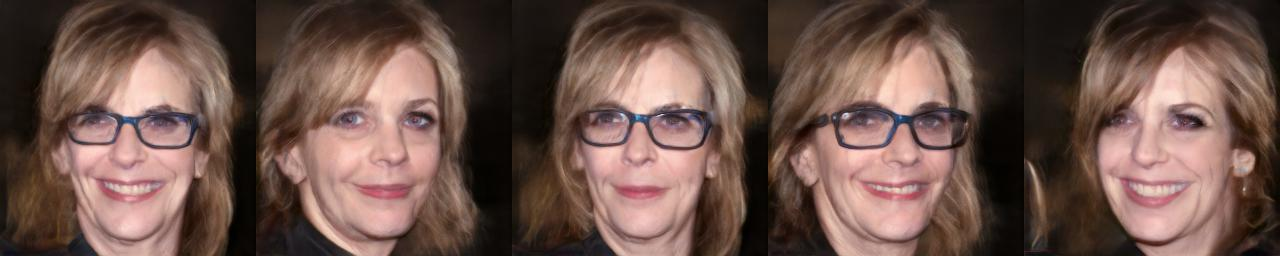

In [ ]:
i = 200
latent_code = np.load(os.path.join(latent_folder, latent_code_names[i]))
images_aug = random_aug(latent_code, boundaries, 5)


image_name = latent_code_names[i].split('.')[0] + '.jpg'
#mani_image = align(inverter, os.path.join(data_folder,image_name))
#images_aug.append(mani_image[np.newaxis])


showed_images = np.concatenate(images_aug, axis=0)
imshow(showed_images, col=showed_images.shape[0])

In [ ]:
aug_folder = 'augment_images2000'
if not os.path.exists(aug_folder):
  os.makedirs(aug_folder)

#im0.save(os.path.join(aug_folder, '003012_1.jpg'))

In [ ]:
for i in range(len(latent_code_names)):
  latent_code = np.load(os.path.join(latent_folder, latent_code_names[i]))
  images_aug = random_aug(latent_code, boundaries, 5)
  image_name = latent_code_names[i].split('.')[0]
  for j in range(len(images_aug)):
    img_array = images_aug[j][0]
    img_obj = Image.fromarray(img_array)
    aug_name = image_name + '_' + str(j) + '.jpg'
    image_path = os.path.join(aug_folder, aug_name)
    img_obj.save(image_path)


In [ ]:
!rm -r augment_images2

In [ ]:
!zip -r augment_images2000.zip augment_images2000

In [ ]:
def back_up(folder):
  t = folder+'.zip'
  !zip -r $t $folder
  files.download(t)

In [ ]:
!zip -r inverted_codes0.zip inverted_codes0

# Combine all latent codes and Download

In [ ]:
subs = [str(i*1000) for i in range(11)]
subs

['0',
 '1000',
 '2000',
 '3000',
 '4000',
 '5000',
 '6000',
 '7000',
 '8000',
 '9000',
 '10000']

In [ ]:
for sub in subs:
  zip_path = 'inverted_codes'+ sub + '.zip'
  print(zip_path)
  if not os.path.exists(zip_path):
    print('not exists')
    break
  latent_folder = os.path.join('./inverted_unzip_folders', sub)
  os.makedirs(latent_folder, exist_ok=True)
  with zipfile.ZipFile(zip_path, 'r') as ziphandler:
    ziphandler.extractall(latent_folder)

inverted_codes0.zip
inverted_codes1000.zip
inverted_codes2000.zip
inverted_codes3000.zip
inverted_codes4000.zip
inverted_codes5000.zip
inverted_codes6000.zip
inverted_codes7000.zip
inverted_codes8000.zip
inverted_codes9000.zip
inverted_codes10000.zip


In [ ]:
all_latent_folder = './all_latent_codes'
os.makedirs(all_latent_folder, exist_ok=True)

for sub in subs:
  print(sub)
  latent_codes_path = os.path.join('./inverted_unzip_folders', sub, 'inverted_codes'+sub)
  if not os.path.exists(latent_codes_path):
    break
  latent_names = [i for i in os.listdir(latent_codes_path) if i.endswith('npy')]
  print('find %s codes'%len(latent_names) )
  for latent_name in latent_names:
    shutil.copy(os.path.join(latent_codes_path, latent_name), all_latent_folder)
  

0
find 964 codes
1000
find 967 codes
2000
find 968 codes
3000
find 959 codes
4000
find 969 codes
5000
find 961 codes
6000
find 969 codes
7000
find 958 codes
8000
find 971 codes
9000
find 974 codes
10000
find 174 codes


In [ ]:
all_latent_codes = [i for i in os.listdir(all_latent_folder) if i.endswith('npy')]
print(len(all_latent_codes))

9834


In [ ]:
import shutil

In [ ]:
!zip -r all_latent_codes.zip all_latent_codes


In [ ]:
all_aug_images_folder = './all_aug_images'
os.makedirs(all_aug_images_folder, exist_ok=True)


for i in range(len(all_latent_codes)):
  latent_code = np.load(os.path.join(all_latent_folder, all_latent_codes[i]))
  images_aug = random_aug(latent_code, boundaries, 5)
  image_name = all_latent_codes[i].split('.')[0]
  for j in range(len(images_aug)):
    img_array = images_aug[j][0]
    img_obj = Image.fromarray(img_array)
    aug_name = image_name + '_' + str(j) + '.jpg'
    image_path = os.path.join(all_aug_images_folder, aug_name)
    img_obj.save(image_path)


In [ ]:
all_latent_codes

In [ ]:
!zip -r all_aug_images.zip all_aug_images
files.download('all_aug_images.zip')